Exploring images with pandas

In [31]:
# Importing intial packages

import numpy as np
import pandas as pd
import os
import cv2
import imutils
from matplotlib import pyplot as plt

from skimage.filters import threshold_local

os.getcwd()

'C:\\Users\\Mikke\\OneDrive\\Skole\\UNI\\7. semester\\BAC\\Image Detection'

In [32]:
# Check content of current dir
for dirname, _, filenames in os.walk('.'):
    print(dirname)

.
.\.ipynb_checkpoints
.\Letters
.\Letters\emnist_source_files
.\License Plates
.\License Plates\annotations
.\License Plates\images
.\Size Recognition
.\__pycache__


In [33]:
# Load and display first image in '.\License Plates\images' with Matplotlib

# Load as pixel array
test_image = cv2.imread('.\License Plates\images\*.jpg')

TypeError: Image data of dtype object cannot be converted to float

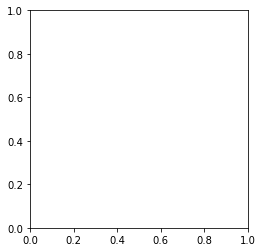

In [34]:
# Display pixel array as image
plt.imshow(test_image)
plt.show()

In [ ]:
# Since Jupyter layers image planes in BGR instead of RGB 
# it needs to be converted to RGB
# This should also be made into a method

test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image_rgb)
plt.show()

Try to isolate the licensplate into a new image

In [ ]:
# This "cleanup" should be in its own method 
# since it needs to be done in all images

# Convert to grey scale - good for analysing
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
gray_image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB)
plt.imshow(gray_image_rgb)
plt.show()

In [ ]:
# Blur to reduce noise - good for analysing contours
gray_image_blurred = cv2.bilateralFilter(gray_image, 11, 17, 17)

gray_image_blurred_rgb = cv2.cvtColor(gray_image_blurred, cv2.COLOR_BGR2RGB)
plt.imshow(gray_image_blurred_rgb)
plt.show()

In [ ]:
# Edge detection /w Canny Edge Method
# OpenCv has it build in so we'll use that
# This is how it works:
# https://docs.opencv.org/master/da/d22/tutorial_py_canny.html

In [ ]:
test_image_edged_30_200_L1 = cv2.Canny(gray_image_blurred, 30, 200)

img_to_show = cv2.cvtColor(test_image_edged_30_200_L1, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
test_image_edged_100_200_L1 = cv2.Canny(gray_image_blurred, 100, 200)

img_to_show = cv2.cvtColor(test_image_edged_100_200_L1, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
test_image_edged_150_200_L1 = cv2.Canny(gray_image_blurred, 150, 200)

img_to_show = cv2.cvtColor(test_image_edged_150_200_L1, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

Since images will be of varrying quality canny edge detection will we done with a rather low threshold for the hysteresis procedure, to ensure high realiability.  (30, 200)

In [ ]:
# Look for contours 
contours = cv2.findContours(test_image_edged_30_200_L1,
                        cv2.RETR_TREE,
                        cv2.CHAIN_APPROX_SIMPLE)
# Sort detected contours from big to small
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

In [ ]:
# Search for rectangular contour with a closed figure.
for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.018 * peri, True)
    
    if len(approx) == 4:
        screenCnt = approx
        break

In [ ]:
# Mask everything except the license plate
mask = np.zeros(test_image_edged_30_200_L1.shape, np.uint8)
new_image = cv2.drawContours(mask, [screenCnt], 0 , 255, -1, )
new_image = cv2.bitwise_and(gray_image_blurred, gray_image_blurred, mask=mask)

img_to_show = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
# Create new cropped image only with the licensplate
(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
cropped = test_image[topx:bottomx+1, topy:bottomy+1]

img_to_show = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
# extract the Value component from the HSV color space and apply adaptive thresholding
# to reveal the characters on the license plate
V = cv2.split(cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV))[2]
T = cv2.threshold(V, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh = (V > T).astype("uint8") * 255
thresh = cv2.bitwise_not(thresh)

# resize the license plate region to a canonical size
cropped = imutils.resize(cropped, width=400)
thresh = imutils.resize(thresh, width=400)

img_to_show = cv2.cvtColor(T, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
## contours sorting method
def sort_contours(contours, reverse=False):
    i = 0
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    (contours, bounding_boxes) = zip(*sorted(zip(contours, bounding_boxes),
                                            key=lambda b: b[1][i], reverse=reverse))
    return contours

contours, _ = cv2.findContours(T, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

width, height = T.shape
dimension = (height, width)

cropped = cv2.resize(cropped, dimension ,interpolation = cv2.INTER_AREA)

test_roi = cropped.copy()
crop_characters = []

digit_w, digit_h = 30, 60

for contour in sort_contours(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    solidity = cv2.contourArea(contour) / float(w * h)
    height_ratio = h / float(cropped.shape[0])
    
    keep_aspect_ratio = aspect_ratio < 1.0
    keep_solidity = solidity > 0.15
    keep_height = height_ratio > 0.2 and height_ratio < 0.95
    
    if keep_aspect_ratio and keep_solidity and keep_height:
        test_roi = cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255, 0), 1) 
        curr_num = T[y:y+h,x:x+w]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        crop_characters.append(curr_num)
        
        
print("Detect {} letters...".format(len(crop_characters)))
img_to_show = cv2.cvtColor(test_roi, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
for i in range(len(crop_characters)):
    img_to_show = cv2.cvtColor(crop_characters[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_to_show)
    plt.show()

## Image processing for our dataset
Siden ovenstående billeder ikke passer særligt godt til vores datasæt, der er brugt til at træne modellen, skal dataet omformateres en smule


In [ ]:
# First try to resize without changing any proportions
img_to_show = cv2.cvtColor(crop_characters[3], cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()
print('Resize to 28x28')
resized_char = cv2.resize(crop_characters[3], dsize=(28, 28))
img_to_show = cv2.cvtColor(resized_char, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

Resultatet ser lovende ud, men lad os se om det ikke kan gøres bedre

In [ ]:
new_char = cv2.copyMakeBorder(crop_characters[3], 4, 4, 19, 19, cv2.BORDER_CONSTANT, None, [0, 0, 0])
img_to_show = cv2.cvtColor(new_char, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()

In [ ]:
resized_char = cv2.resize(new_char, dsize=(28, 28))
img_to_show = cv2.cvtColor(resized_char, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_show)
plt.show()